In [1]:
%matplotlib inline
import numpy, scipy, matplotlib.pyplot as plt, IPython.display as ipd
import librosa, librosa.display
import stanford_mir; stanford_mir.init()

[&larr; Back to Index](index.html)

# Novelty Functions

To detect note onsets, we want to locate sudden changes in the audio signal that mark the beginning of transient regions. Often, an increase in the signal's amplitude envelope will denote an onset candidate. However, that is not always the case, for notes can change from one pitch to another without changing amplitude, e.g. a violin playing slurred notes.

**Novelty functions** are functions which denote local changes in signal properties such as energy or spectral content. We will look at two novelty functions:

1. Energy-based novelty functions (FMP, p. 306)
2. Spectral-based novelty functions (FMP, p. 309)

## Energy-based Novelty Functions

Playing a note often coincides with a sudden increase in signal energy. To detect this sudden increase, we will compute an **energy novelty function** (FMP, p. 307):

1. Compute the short-time energy in the signal.
2. Compute the first-order difference in the energy.
3. Half-wave rectify the first-order difference.

First, load an audio file into the NumPy array `x` and sampling rate `sr`. 

In [2]:
x, sr = librosa.load('audio/mono.wav')
print(x.shape, sr)

(289392,) 22050


Plot the signal:

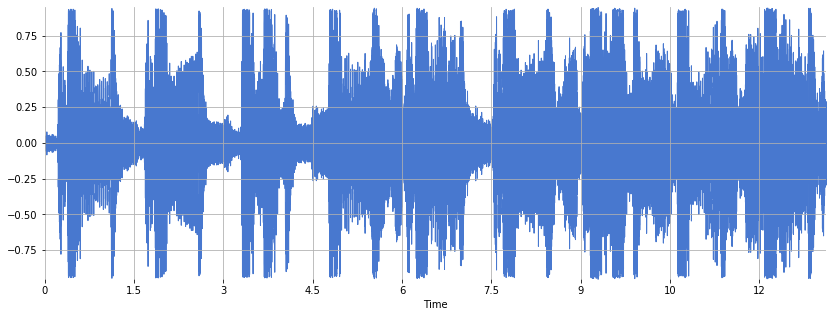

In [3]:
plt.figure(figsize=(14, 5))
librosa.display.waveplot(x, sr)

Listen:

In [4]:
ipd.Audio(x, rate=sr)

### RMS Energy

[`librosa.feature.rmse`](http://librosa.github.io/librosa/generated/librosa.feature.rmse.html#librosa.feature.rmse) returns the root-mean-square (RMS) energy for each frame of audio. We will compute the RMS energy as well as its first-order difference.

In [6]:
hop_length = 512
frame_length = 1024
rms = librosa.feature.rms(x, frame_length=frame_length, hop_length=hop_length).flatten()
rms_diff = numpy.zeros_like(rms)
rms_diff[1:] = numpy.diff(rms)

In [8]:
print(rms.shape)
print(rms_diff.shape)

(566,)
(566,)


To obtain an energy novelty function, we perform **half-wave rectification** (FMP, p. 307) on `rmse_diff`, i.e. any negative values are set to zero. Equivalently, we can apply the function $\max(0, x)$:

In [10]:
energy_novelty = numpy.max([numpy.zeros_like(rms_diff), rms_diff], axis=0)

Plot all three functions together:

In [11]:
frames = numpy.arange(len(rms))
t = librosa.frames_to_time(frames, sr=sr)

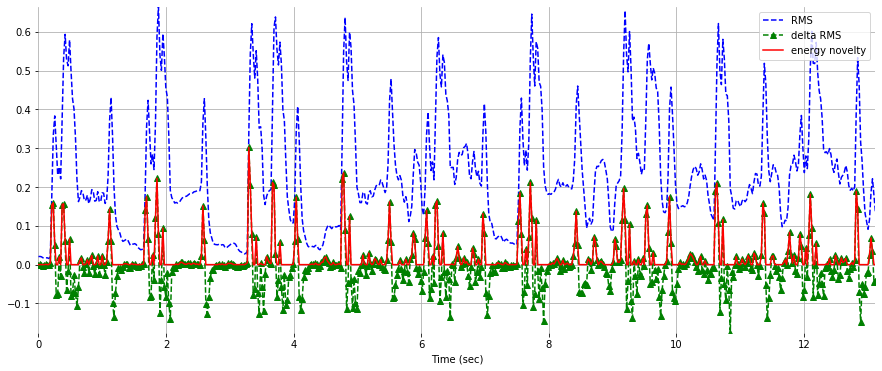

In [12]:
plt.figure(figsize=(15, 6))
plt.plot(t, rms, 'b--', t, rms_diff, 'g--^', t, energy_novelty, 'r-')
plt.xlim(0, t.max())
plt.xlabel('Time (sec)')
plt.legend(('RMS', 'delta RMS', 'energy novelty')) 

### Log Energy

The human perception of sound intensity is logarithmic in nature. To account for this property, we can apply a logarithm function to the energy before taking the first-order difference.

Because $\log(x)$ diverges as $x$ approaches zero, a common alternative is to use $\log(1 + \lambda x)$. This function equals zero when $x$ is zero, but it behaves like $\log(\lambda x)$ when $\lambda x$ is large. This operation is sometimes called **logarithmic compression** (FMP, p. 310).

In [13]:
log_rms = numpy.log1p(10*rms)
log_rms_diff = numpy.zeros_like(log_rms)
log_rms_diff[1:] = numpy.diff(log_rms)

In [14]:
log_energy_novelty = numpy.max([numpy.zeros_like(log_rms_diff), log_rms_diff], axis=0)

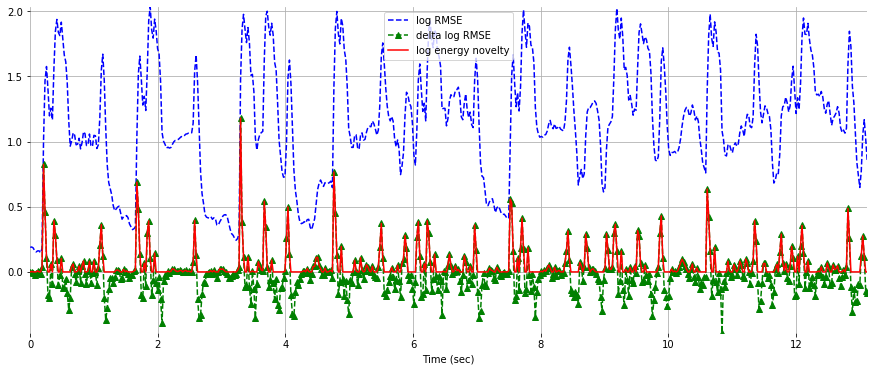

In [15]:
plt.figure(figsize=(15, 6))
plt.plot(t, log_rms, 'b--', t, log_rms_diff, 'g--^', t, log_energy_novelty, 'r-')
plt.xlim(0, t.max())
plt.xlabel('Time (sec)')
plt.legend(('log RMSE', 'delta log RMSE', 'log energy novelty')) 

## Spectral-based Novelty Functions

There are two problems with the energy novelty function: 

1. It is sensitive to energy fluctuations belonging to the same note.
2. It is not sensitive to spectral fluctuations between notes where amplitude remains the same.

For example, consider the following audio signal composed of pure tones of equal magnitude:

In [16]:
sr = 22050
def generate_tone(midi):
    T = 0.5
    t = numpy.linspace(0, T, int(T*sr), endpoint=False)
    f = librosa.midi_to_hz(midi)
    return numpy.sin(2*numpy.pi*f*t)

In [26]:
x = numpy.concatenate([generate_tone(midi) for midi in [48, 52, 55, 60, 64, 67, 72, 76, 79, 84]])
x, sr = librosa.load('audio/mono.wav')

Listen:

In [27]:
ipd.Audio(x, rate=sr)

The energy novelty function remains roughly constant:

In [28]:
hop_length = 512
frame_length = 1024
rmse = librosa.feature.rms(x, frame_length=frame_length, hop_length=hop_length).flatten()
rmse_diff = numpy.zeros_like(rmse)
rmse_diff[1:] = numpy.diff(rmse)

In [29]:
energy_novelty = numpy.max([numpy.zeros_like(rmse_diff), rmse_diff], axis=0)

In [30]:
frames = numpy.arange(len(rmse))
t = librosa.frames_to_time(frames, sr=sr)

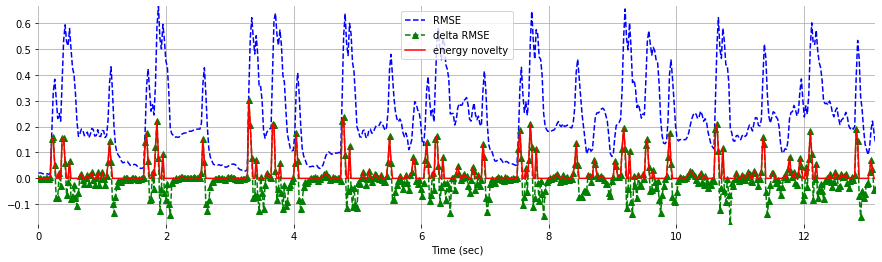

In [31]:
plt.figure(figsize=(15, 4))
plt.plot(t, rmse, 'b--', t, rmse_diff, 'g--^', t, energy_novelty, 'r-')
plt.xlim(0, t.max())
plt.xlabel('Time (sec)')
plt.legend(('RMSE', 'delta RMSE', 'energy novelty')) 

Instead, we will compute a **spectral novelty function** (FMP, p. 309):

1.  Compute the log-amplitude spectrogram.
2.  Within each frequency bin, $k$, compute the energy novelty function as shown earlier, i.e. (a) first-order difference, and (b) half-wave rectification.
3.  Sum across all frequency bins, $k$.

Luckily, `librosa` has [`librosa.onset.onset_strength`](http://librosa.github.io/librosa/generated/librosa.onset.onset_strength.html) which computes a novelty function using spectral flux.

In [32]:
spectral_novelty = librosa.onset.onset_strength(x, sr=sr)

In [33]:
frames = numpy.arange(len(spectral_novelty))
t = librosa.frames_to_time(frames, sr=sr)

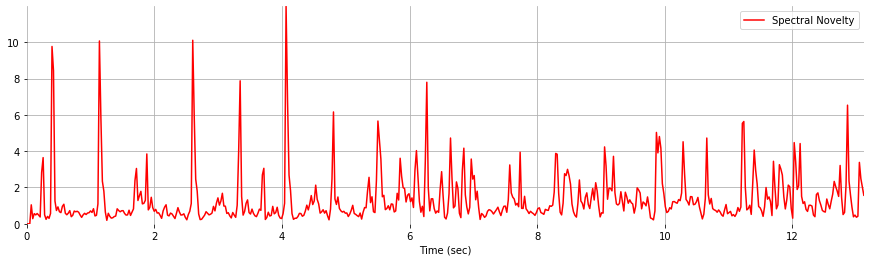

In [34]:
plt.figure(figsize=(15, 4))
plt.plot(t, spectral_novelty, 'r-')
plt.xlim(0, t.max())
plt.xlabel('Time (sec)')
plt.legend(('Spectral Novelty',))

## Questions

Novelty functions are dependent on `frame_length` and `hop_length`. Adjust these two parameters. How do they affect the novelty function?

Try with other audio files. How do the novelty functions compare?

In [23]:
ls audio

125_bounce.wav                  jangle_pop.mp3
58bpm.wav                       latin_groove.mp3
README.md                       oboe_c6.wav
brahms_hungarian_dance_5.mp3    prelude_cmaj.wav
busta_rhymes_hits_for_days.mp3  simple_loop.wav
c_strum.wav                     simple_piano.wav
clarinet_c6.wav                 sir_duke_piano_fast.mp3
classic_rock_beat.wav           sir_duke_piano_slow.mp3
conga_groove.wav                sir_duke_trumpet_fast.mp3
drum_samples/                   sir_duke_trumpet_slow.mp3
funk_groove.mp3                 tone_440.wav


[&larr; Back to Index](index.html)